###  Below are the helper functions 

In [2]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
%matplotlib inline

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='YUV', spatial_size=(32, 32),
                        hist_bins=32, orient=8, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, debug=False):
    if debug:
        hog_vis = True
        hog_feat = True
        hist_feat = True
        spatial_feat = True
        hog_image_list = list()
        hog_channel = "ALL"
    else:
        hog_vis = False
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    if debug:
                        hog_feature, hog_image = get_hog_features(feature_image[:,:,channel], 
                                                orient, pix_per_cell, cell_per_block,
                                                vis=hog_vis, feature_vec=True)
                        hog_image_list.append(hog_image)
                        hog_features.append(hog_feature)
                    else:
                        hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                                orient, pix_per_cell, cell_per_block, 
                                                vis=hog_vis, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=hog_vis, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
        if debug:
            plt.figure(figsize=(20,20))
            plt.subplot(4,2,1)
            plt.imshow(image)
            plt.title('origin img')

            plt.subplot(4,2,2)
            plt.imshow(feature_image)
            plt.title('feature image: {0}'.format(color_space))

            plt.subplot(4,2,3)
            plt.plot(spatial_features)
            plt.title('Spatially Binned Features')

            plt.subplot(4,2,4)
            plt.plot(hist_features)
            plt.title('color hist')

            index = 5
            for i, img_data in enumerate(hog_image_list):
                plt.subplot(4,2, index)
                plt.imshow(img_data, cmap='gray')
                plt.title('hog image @ channel: {0}'.format(i))
                index += 1
            plt.show()
    # Return list of feature vectors
    return features



### visualize features

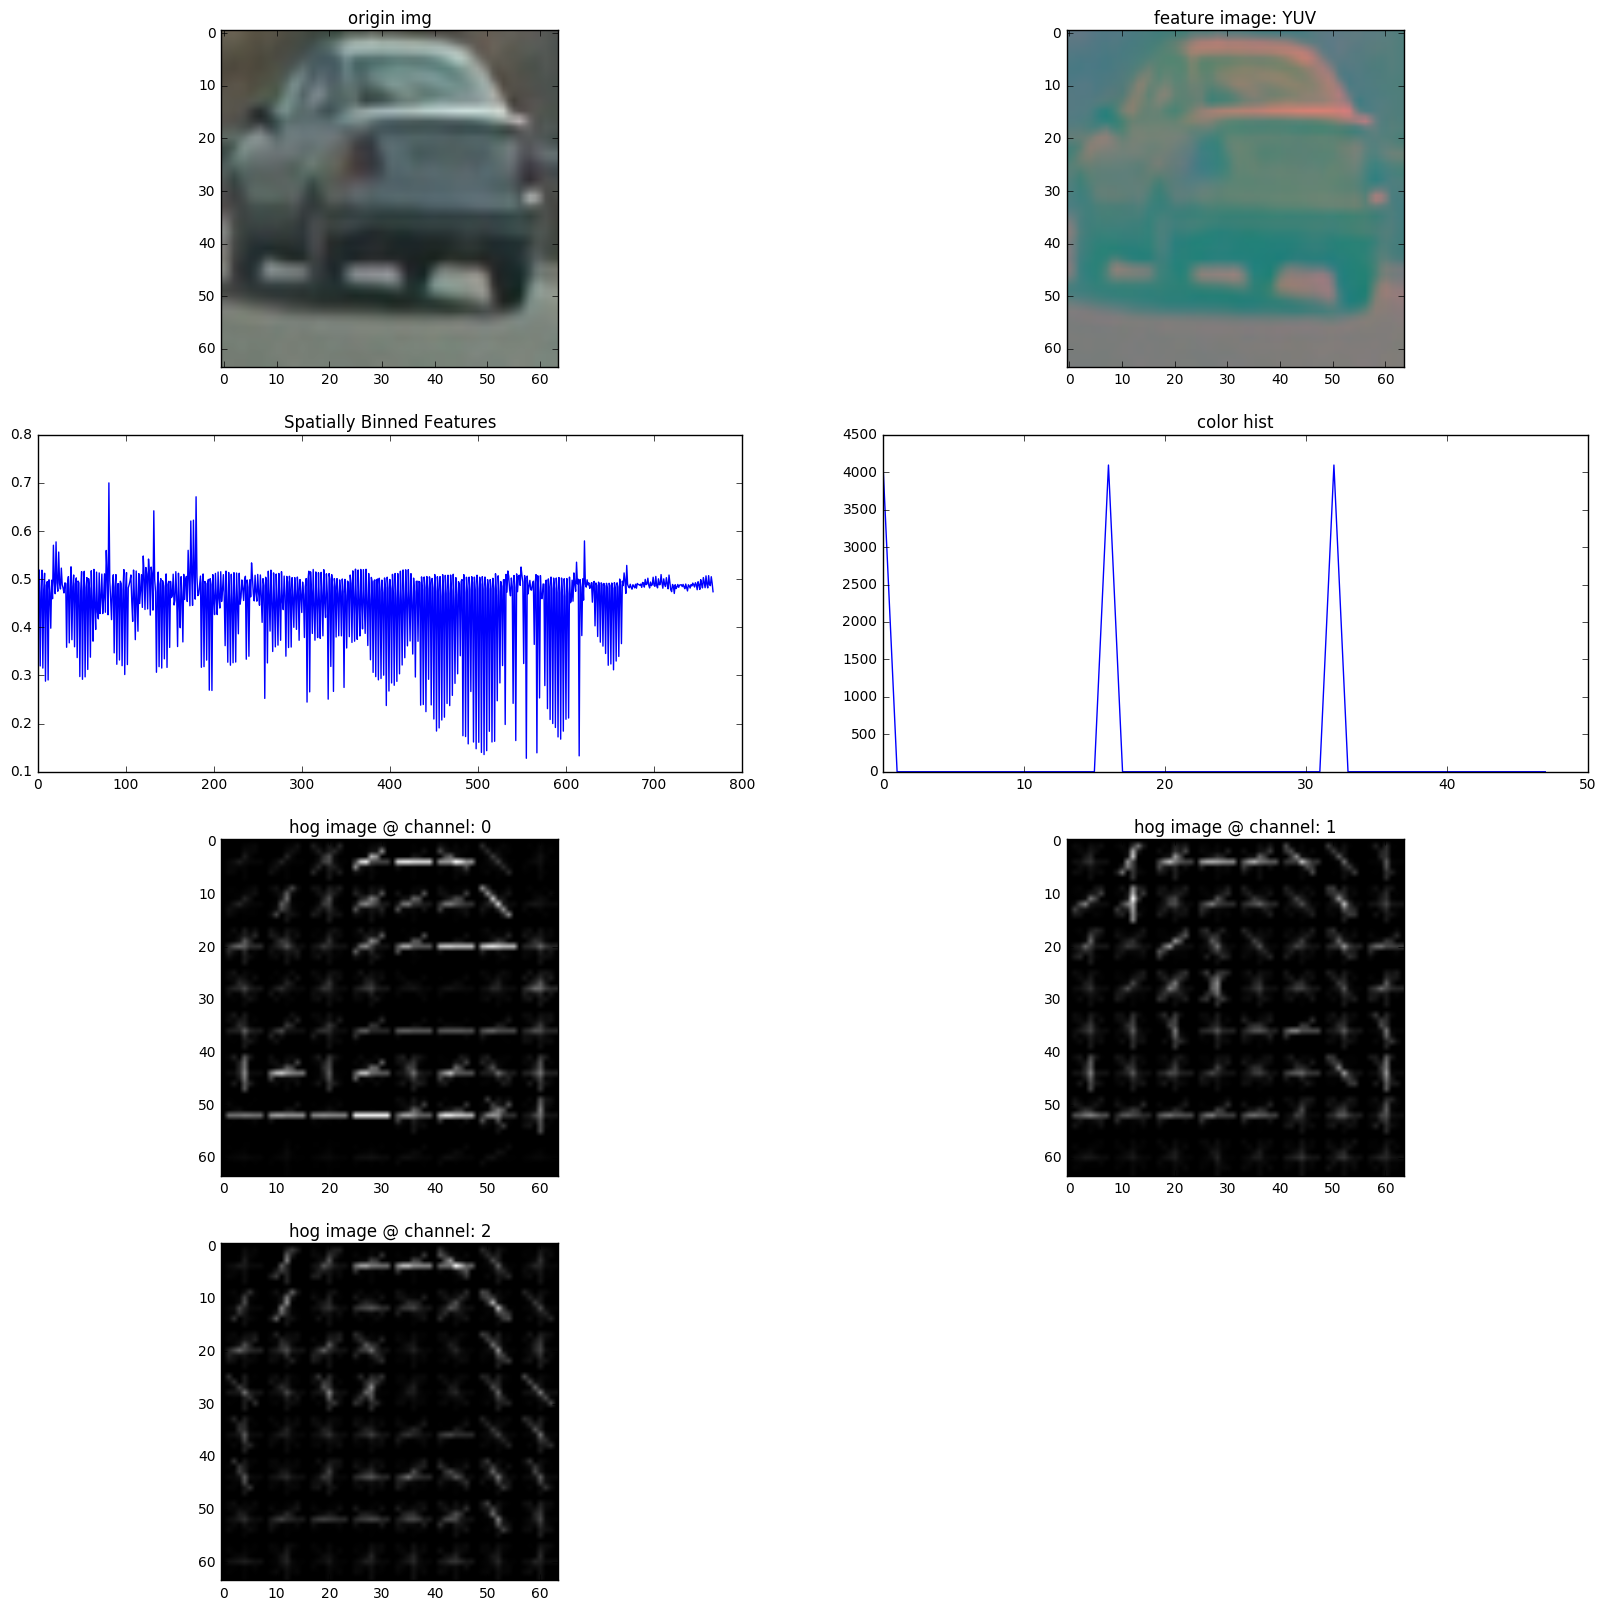

In [3]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins

cars = ["vehicles/GTI_Right/image0035.png"]
test = extract_features(cars, color_space=color_space, 
                 spatial_size=spatial_size, hist_bins=hist_bins, 
                 orient=orient, pix_per_cell=pix_per_cell, 
                 cell_per_block=cell_per_block, 
                 debug=True)

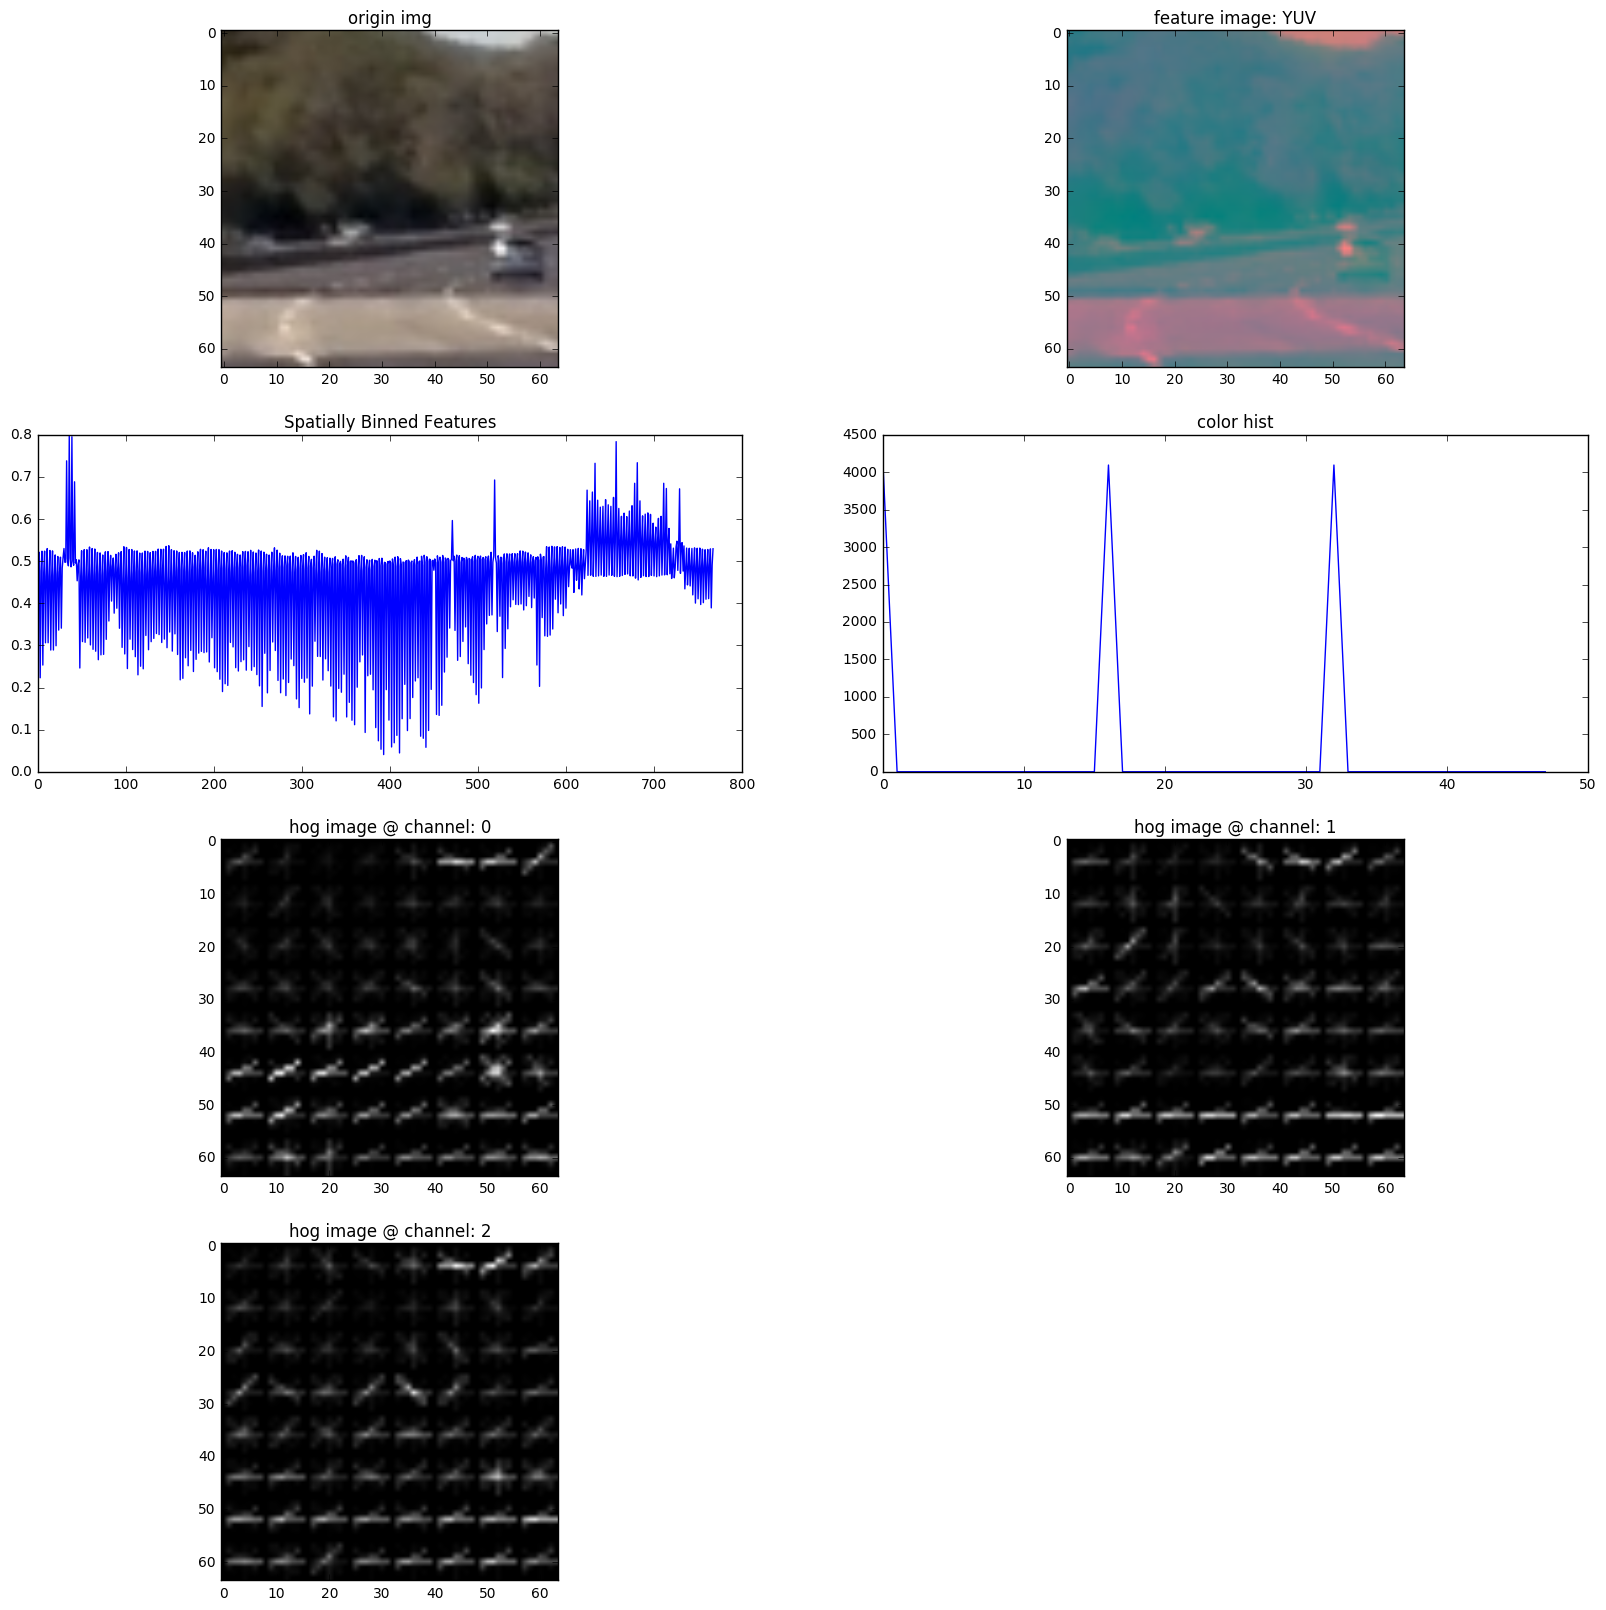

In [4]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins

cars = ["non-vehicles/Extras/extra66.png"]
test = extract_features(cars, color_space=color_space, 
                 spatial_size=spatial_size, hist_bins=hist_bins, 
                 orient=orient, pix_per_cell=pix_per_cell, 
                 cell_per_block=cell_per_block, 
                 debug=True)


######  The plots above show the  spatially binned features ,  color hist and hog features
######  As you can see  the hog features is the easiest  features to  tell  if  the object is a car or not
######  So I decide to extract  hog  features only from each frame

###  Generate Features and Labels

In [5]:
import numpy as np
import os
from random import shuffle

# function to extract hog feature from image
def hog_features(img):
    orientations = 8
    pixels_per_cell = 8
    cells_per_block = 2
    return hog(img, orientations=orientations,
               pixels_per_cell=(pixels_per_cell, pixels_per_cell),
               cells_per_block=(cells_per_block, cells_per_block),
               transform_sqrt=False, 
               visualise=False, 
               feature_vector=True)

# function to extract three channels hog features from image
def extract_features(img):
    # convert color_space from RGB to YUV
    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    features_y = hog_features(feature_image[:, :, 0])
    features_u = hog_features(feature_image[:, :, 1])
    features_v = hog_features(feature_image[:, :, 2])
    return np.concatenate((features_y, features_u, features_v))

# walk through the directory to collect all png files path
def get_files(dir_path, extension="png"):
    file_list = []
    for root, dirs, files in os.walk(dir_path, topdown=False):
        for name in files:
            if name.split(".")[-1].lower() == extension:
                file_list.append(os.path.join(root, name))
    shuffle(file_list)
    return file_list


In [6]:
# Extract Features and Generate Labels
labels = []
features = []

# create cars features and labels
car_image_path_list = get_files('vehicles')
print("car file num:", len(car_image_path_list))
for png_file in car_image_path_list:
    img = mpimg.imread(png_file, format="uint8")
    features.append(extract_features(img))
    labels.append(True)
    
non_car_image_path_list = get_files('non-vehicles')
print("non-car file num:", len(non_car_image_path_list))
for i in non_car_image_path_list:
    img = mpimg.imread(i, format="uint8")
    features.append(extract_features(img))
    labels.append(False)



car file num: 8792
non-car file num: 8968


In [7]:
# use StandardScaler() to normalize the data
X_scaler= StandardScaler().fit(features)
features = X_scaler.transform(features)

In [8]:
# Define the labels vector
print("label length:", len(labels))
print("feature lenght:", len(features))
# use train_test_split() to split the data to Train and Test set
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, 
                                                      stratify=labels, random_state=77)

print("train label length:", len(labels_train))
print("train feature lenght:", len(features_train))
print("test label length:", len(labels_test))
print("test feature lenght:", len(features_test))
print("num of features:", len(features_train[0]))

label length: 17760
feature lenght: 17760
train label length: 14208
train feature lenght: 14208
test label length: 3552
test feature lenght: 3552
num of features: 4704


In [9]:
# save the traning data.
# I don't want to spend 2 mins to regenerate the data again...
import pickle
training_file = "training_data.p"
with open(training_file, mode='wb') as w:
    pickle.dump({"features_train": features_train, "labels_train": labels_train,
                 "features_test":features_test, "labels_test":labels_test}, w)


In [10]:
if 0:
    training_file = "training_data.p"
    with open(training_file, mode='rb') as f:
        train_data = pickle.load(f)

    features_train, labels_train = train_data['features_train'], train_data['labels_train']
    features_test, labels_test = train_data['features_test'], train_data['labels_test']


In [11]:
# Time to train the data
# I choose LinearSVC with all default parameters
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(features_train, labels_train)
print('Test Accuracy of LinearSVC: {0}'.format(svc.score(features_test, labels_test)))



Test Accuracy of LinearSVC: 0.9864864864864865


In [12]:
clf_file = "clf.p"
with open(clf_file, mode='wb') as w:
    pickle.dump({"clf": svc}, w)

In [13]:
if 0:
    with open(clf_file, mode='rb') as f:
        clf = pickle.load(f)["clf"]
    print('Test Accuracy of LinearSVC: {0}'.format(clf.score(features_test, labels_test)))

In [14]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.8, 0.8)):
    height, width = img.shape[:2]
    window_width, window_height = xy_window
    # If x and/or y start/stop positions not defined, set to image size
    x_start, x_stop = x_start_stop
    y_start, y_stop = y_start_stop
    if x_start is None:
        x_start = int(img.shape[1]/2)
    if x_stop is None:
        x_stop = img.shape[1]
        
    if y_start is None:
        y_start = 0
    if y_stop is None:
        y_stop = height
    
    # Compute the span of the region to be searched    
    xspan = x_stop - x_start
    yspan = y_stop - y_start
    
    # Compute the number of pixels per step in x/y
    pix_per_step_x = np.int(xy_window[0] * (1. - xy_overlap[0]))
    pix_per_step_y = np.int(xy_window[1] * (1. - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    n_window_x = np.int(xspan/pix_per_step_x) - 1
    n_window_y = np.int(yspan/pix_per_step_y) - 1
    # Initialize a list to append window positions to
    window_list = list()

    for window_index_y in range(n_window_y):
        start_y = y_start + window_index_y*pix_per_step_y
        end_y = start_y + window_height
        for window_index_x in range(n_window_x):
            start_x = x_start + window_index_x*pix_per_step_x
            end_x = start_x + window_width
            window_list.append(((start_x, start_y),(end_x, end_y)))
    return window_list

windows num: 585


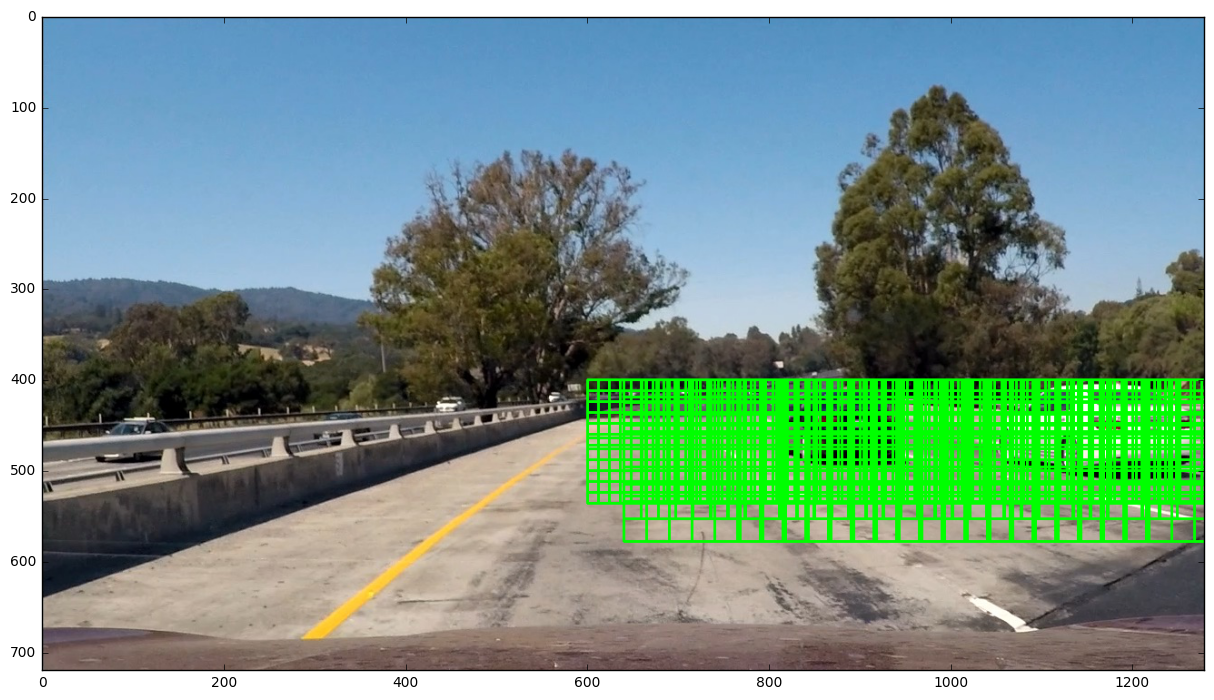

In [15]:
# fomrat: (window_size), [x_start, x_stop], [y_start, y_stop]
roi = [([400, 500], [600, 1280], (64, 64)),
       ([400, 500], [640, 1280], (96, 96)),
       ([400, 500], [640, 1280], (128, 128))]

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 255, 0), thick=2):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for index, bbox in enumerate(bboxes):
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Get x,y data for each window and return the list of bounding boxes for the search windows.
def get_roi_windows(roi, img):
    windows_list = []
    for y_range, x_range, window_size in roi:
        windows = slide_window(img, y_start_stop=y_range, x_start_stop=x_range,
                    xy_window=window_size, xy_overlap=(0.8, 0.8))
        windows_list.extend(windows)
    return windows_list

img_test1 = mpimg.imread('test_images/test1.jpg')
windows  = get_roi_windows(roi, img_test1)
print("windows num:", len(windows))
plt.figure(figsize=(15,15))
process_img = draw_boxes(img_test1, windows )
plt.imshow(process_img)
plt.show()

In [16]:
def search_windows(img, windows, clf, scaler):
    # Create an empty list to receive positive detection windows
    on_windows = list()
    
    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from original image
        # and resize the window to 64x64
        window_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        # Extract features for the resized window image
        features = extract_features(window_img)
        # Normalize the extracted features.
        features = scaler.transform(np.array(features).reshape(1, -1))
        # Save the window if prediction is True.
        prediction = clf.predict(features)
        if prediction == 1:# and clf.decision_function(features) > 0.4:
            on_windows.append(window)
                
    # Return the windows with positive detections.
    return on_windows

 

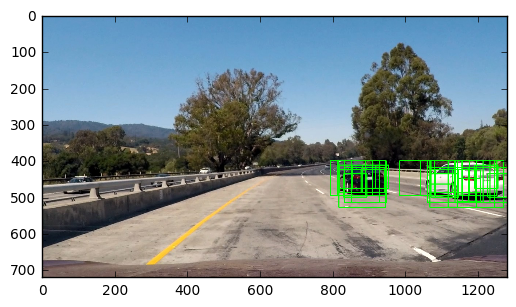

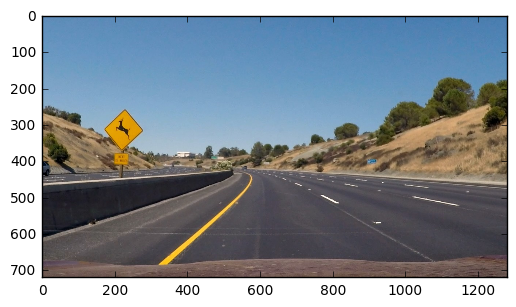

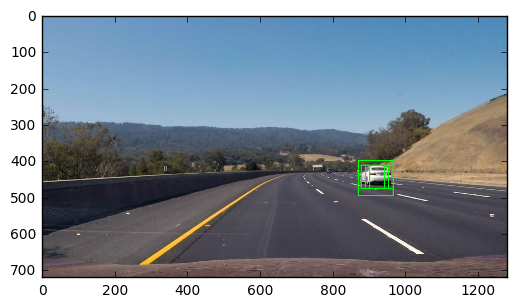

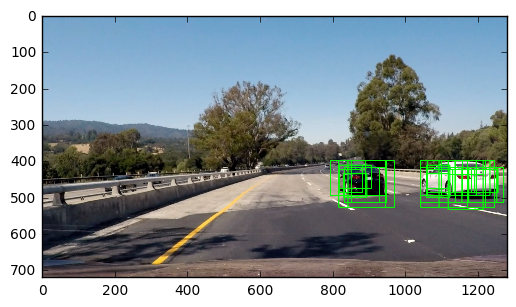

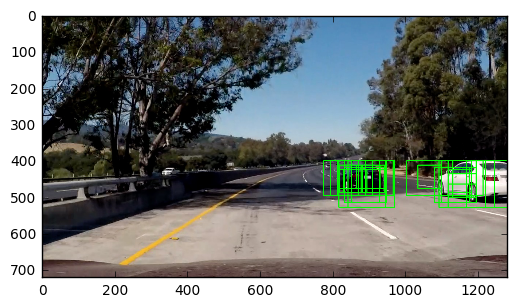

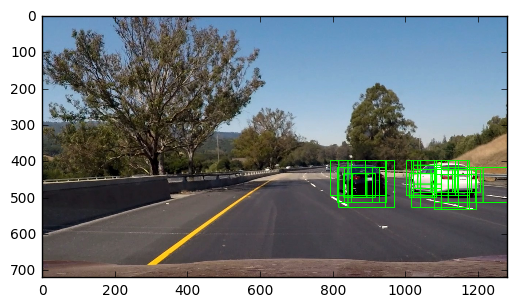

In [17]:
for i in glob.glob("test_images/*.jpg"):
    img = mpimg.imread(i, format="uint8")
    windows = get_roi_windows(roi, img)
    windows = search_windows(img, windows, svc, X_scaler)

    img = draw_boxes(img, windows)
    plt.imshow(img)
    plt.show()


In [50]:
from scipy.ndimage.measurements import label

# generate a list of bounding boxes for the heatmap.
def get_heatmap(img, bbox_list, thresh=5):
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    sec_thresh = np.floor(np.amax(heatmap)/2)
    if thresh > sec_thresh:
        thresh = sec_thresh
    heatmap[heatmap <= thresh] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


2 cars found


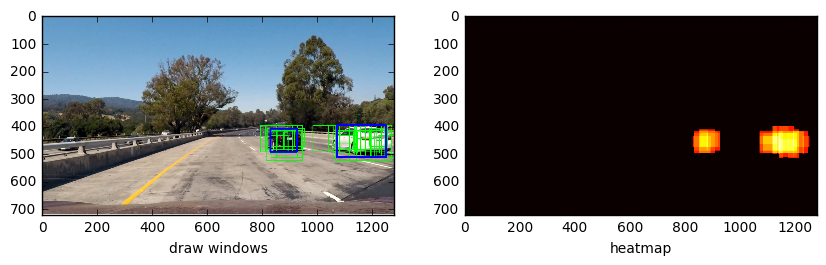

0 cars found


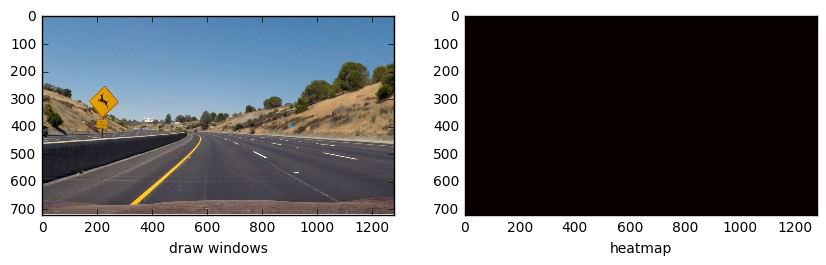

1 cars found


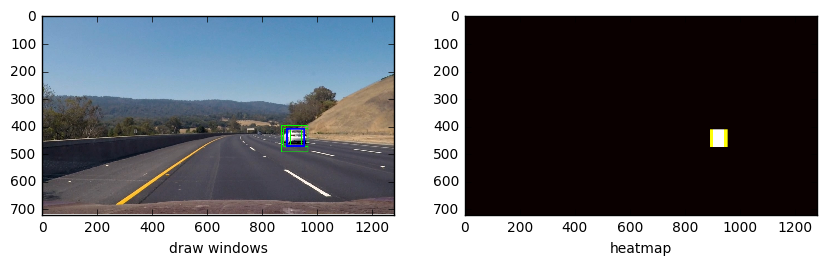

2 cars found


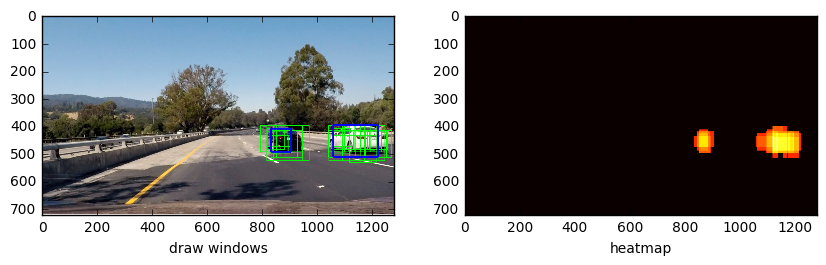

2 cars found


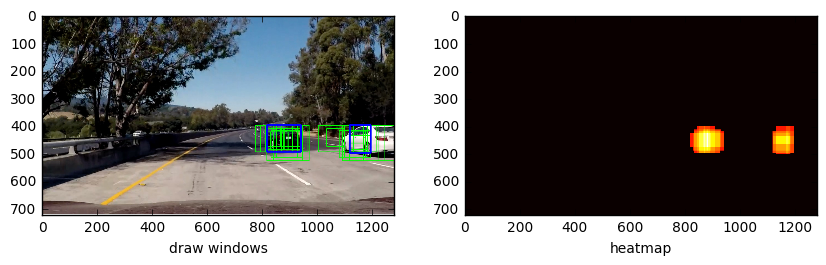

2 cars found


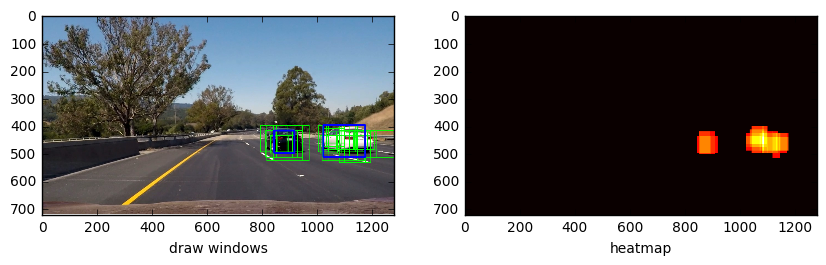

In [51]:
for i in glob.glob("test_images/*.jpg"):
    img = mpimg.imread(i, format="uint8")
    windows = get_roi_windows(roi, img)
    windows = search_windows(img, windows, svc, X_scaler)
    
    img = draw_boxes(img, windows)
    
    heatmap = get_heatmap(img, windows)
    labels = label(heatmap)
    print(labels[1], 'cars found')
    final_img = draw_labeled_bboxes(img, labels)
    plt.figure(figsize=(10,10))
    plt.subplot(2, 2, 1)
    plt.imshow(final_img)
    plt.xlabel('draw windows')
    plt.subplot(2, 2, 2)
    plt.imshow(heatmap, cmap='hot')
    plt.xlabel('heatmap')
    plt.show()
    

In [65]:
# generate the heatmap for each frame in the video
# I am using Deque here to store the heatmap data from previous frames
def get_heatmaps(img, windows_queue, thresh=5):
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    for bbox_list in windows_queue:
        for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    sec_thresh = np.floor(np.amax(heatmap)/2)
    heatmap[heatmap <= thresh] = 0
    return heatmap
    
from collections import deque
windows_queue = deque(maxlen=4)

# Pipeline to process each frames
def process_image(img, q=windows_queue):
    windows = get_roi_windows(roi, img)
    windows = search_windows(img, windows, svc, X_scaler)
    windows_queue.append(windows)
    heatmap = get_heatmaps(img, windows_queue)
    labels = label(heatmap)
    final_img = draw_labeled_bboxes(img, labels)
    return final_img   


In [66]:
# clear the cache
windows_queue.clear()
print(windows_queue)

deque([], maxlen=4)


In [61]:
from moviepy.editor import VideoFileClip
filename = 'test_video.mp4'
result_movie = 'test_result_video.mp4'
clip = VideoFileClip(filename)
vid_clip = clip.fl_image(process_image)
vid_clip.write_videofile(result_movie, audio=False)


[MoviePy] >>>> Building video test_result_video.mp4
[MoviePy] Writing video test_result_video.mp4




  0%|          | 0/39 [00:00<?, ?it/s]

  3%|▎         | 1/39 [00:01<00:53,  1.40s/it]

  5%|▌         | 2/39 [00:02<00:53,  1.46s/it]

  8%|▊         | 3/39 [00:04<00:53,  1.48s/it]

 10%|█         | 4/39 [00:06<00:51,  1.48s/it]

 13%|█▎        | 5/39 [00:07<00:49,  1.46s/it]

 15%|█▌        | 6/39 [00:08<00:47,  1.44s/it]

 18%|█▊        | 7/39 [00:10<00:45,  1.43s/it]

 21%|██        | 8/39 [00:11<00:43,  1.41s/it]

 23%|██▎       | 9/39 [00:12<00:41,  1.39s/it]

 26%|██▌       | 10/39 [00:14<00:39,  1.37s/it]

 28%|██▊       | 11/39 [00:16<00:41,  1.49s/it]

 31%|███       | 12/39 [00:17<00:39,  1.47s/it]

 33%|███▎      | 13/39 [00:18<00:38,  1.49s/it]

 36%|███▌      | 14/39 [00:20<00:37,  1.49s/it]

 38%|███▊      | 15/39 [00:21<00:34,  1.45s/it]

 41%|████      | 16/39 [00:23<00:33,  1.45s/it]

 44%|████▎     | 17/39 [00:24<00:32,  1.46s/it]

 46%|████▌     | 18/39 [00:26<00:31,  1.50s/it]

 49%|████▊     | 19/39 [00:28<00:33,  1.66s/it]

 51%|█████▏    | 20/39 [00:29<00:30,

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_result_video.mp4 



In [67]:
windows_queue.clear()
print(windows_queue)

deque([], maxlen=4)


In [68]:
filename = 'project_video.mp4'
result_movie = 'project_video_result.mp4'
clip = VideoFileClip(filename)
vid_clip = clip.fl_image(process_image)
vid_clip.write_videofile(result_movie, audio=False)



[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:01<28:40,  1.37s/it]

  0%|          | 2/1261 [00:02<28:56,  1.38s/it]

  0%|          | 3/1261 [00:04<29:27,  1.40s/it]

  0%|          | 4/1261 [00:05<29:10,  1.39s/it]

  0%|          | 5/1261 [00:07<29:17,  1.40s/it]

  0%|          | 6/1261 [00:08<30:14,  1.45s/it]

  1%|          | 7/1261 [00:10<30:05,  1.44s/it]

  1%|          | 8/1261 [00:11<29:33,  1.42s/it]

  1%|          | 9/1261 [00:12<29:57,  1.44s/it]

  1%|          | 10/1261 [00:14<29:42,  1.43s/it]

  1%|          | 11/1261 [00:15<29:24,  1.41s/it]

  1%|          | 12/1261 [00:17<31:09,  1.50s/it]

  1%|          | 13/1261 [00:18<31:21,  1.51s/it]

  1%|          | 14/1261 [00:20<31:19,  1.51s/it]

  1%|          | 15/1261 [00:21<31:49,  1.53s/it]

  1%|▏         | 16/1261 [00:23<31:52,  1.54s/it]

  1%|▏         | 17/1261 [00:25<31:46,  1.53s/it]

  1%|▏         | 18/1261 [00:26<30:53,  1.49s/it]

  2%|▏         | 19/1261 [00:27<29:38,  1.43s/i

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

